In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2
from numpy.fft import fft, ifft, ifftshift, fftshift
# In the case 2ab=sigma^2, the Feller square-root process can be obtained from the square of an Ornstein–Uhlenbeck process.
# CIR where 2ab > sigma^2

In [2]:
# Used in CIR model and Heston Stochastic Vol Model 
# Define parameters and time grid
npaths = 2000  # number of paths
T = 1  # time horizon
nsteps = 200  # number of time steps
dt = T / nsteps  # time step
t = np.arange(0, T + dt, dt)   # observation times

# Model parameters
alpha = 5
mu = 0.2
sigma = 0.4  # model parameters
X0 = 0.03  # initial value
Feller_ratio = (4 * alpha * mu) / sigma**2  # for monitoring

# Allocate and initialize all paths
# X = np.column_stack([X0 * np.ones(npaths), np.zeros((nsteps, npaths))])
X = np.zeros((nsteps+1, npaths))
X[0,:] = X0

# Euler-Maruyama method with analytical moments
N = np.random.randn(nsteps, npaths)  # sample standard normal random numbers
a = sigma**2 / alpha * (np.exp(-alpha * dt) - np.exp(-2 * alpha * dt))  # with analytic moments
b = mu * sigma**2 / (2 * alpha) * (1 - np.exp(-alpha * dt))**2  # with analytic moments
for i in range(nsteps):  # compute and accumulate the increments
    X[i+1,:] = X[i,:] + alpha*(mu-X[i,:])*dt + sigma*np.sqrt(X[i,:]*dt)*N[i,:] # plain
    # X[i + 1, :] = mu + (X[i, :] - mu) * np.exp(-alpha * dt) + np.sqrt(a * X[i, :] + b) * N[i, :] # analytic moments
    X[i + 1, :] = np.maximum(X[i + 1, :], np.zeros(npaths)) #checking to make sure X is above 0 as every step
    
# Exact method
# d = 4*alpha*mu/sigma**2 # degrees of freedom of the non-central chi square distribution
# k = sigma**2*(1-np.exp(-alpha*dt))/(4*alpha)
# for i in range(nsteps): # compute and accumulate the increments
#    lamb = 4*alpha*X[i,:]/(sigma**2*(np.exp(alpha*dt)-1))
#    #X(i+1,:) = ncx2.ppf(np.random.rand(1,npaths),d,lambda)*k # 80000 times slower than EM
#    X[i+1,:] = ncx2(d,lamb,1,npaths)*k # 40 times slower than EM - with analytic moments
## if Euler Maruyama needs end value use last method ^ instead for accurate solutions

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_1187/2369577498.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(t, mu * np.ones_like(t), 'k--', label='$\mu$')
/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_1187/2369577498.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Paths of a Feller square-root process dX = $\\alpha(\mu-X)dt + sigmaX^{1/2}$dW')


Text(0.5, 1.0, 'Paths of a Feller square-root process dX = $\\alpha(\\mu-X)dt + sigmaX^{1/2}$dW')

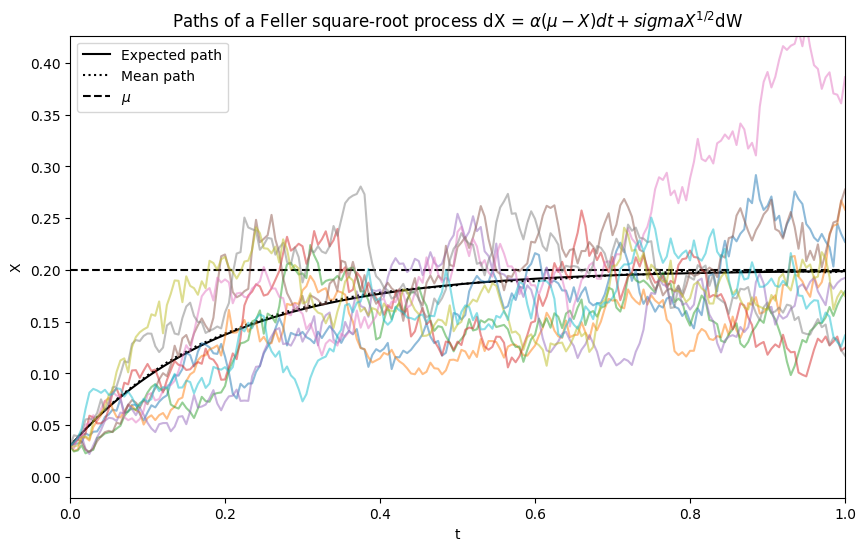

In [3]:
# Expected, mean, and sample paths
plt.figure(figsize=(10, 6))
EX = mu + (X0 - mu) * np.exp(-alpha * t)  # expected path
plt.plot(t, EX, 'k', label='Expected path')
plt.plot(t, np.mean(X, axis=1), ':k', label='Mean path')
plt.plot(t, mu * np.ones_like(t), 'k--', label='$\mu$')
plt.plot(t, X[:, ::200], alpha=0.5)
plt.legend()
plt.xlabel('t')
plt.ylabel('X')
sdevinfty = sigma * np.sqrt(mu / (2 * alpha))
plt.ylim([-0.02, mu + 4 * sdevinfty])
plt.xlim([0,T])
plt.title('Paths of a Feller square-root process dX = $\\alpha(\mu-X)dt + sigmaX^{1/2}$dW')

Text(0.5, 1.0, 'Probability density function of a Feller square-root process at different times')

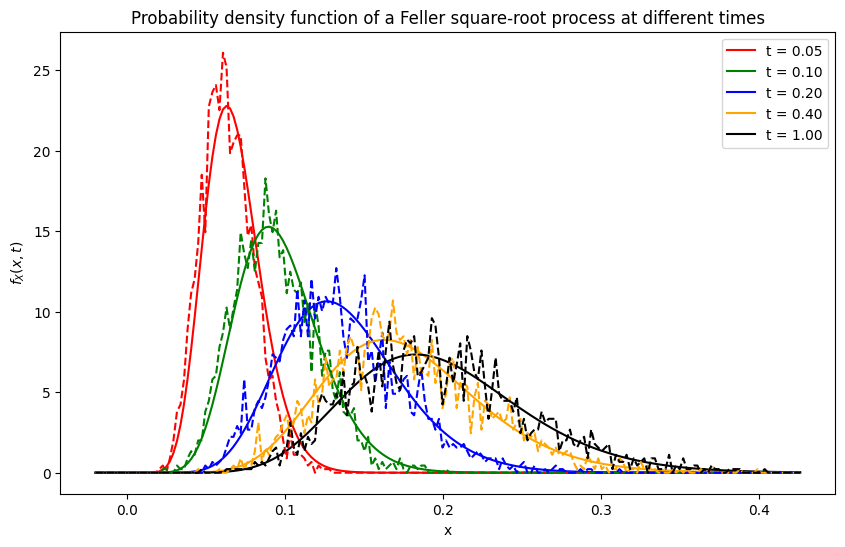

In [4]:
t2 = np.array([0.05, 0.1, 0.2, 0.4, 1.0])
x = np.linspace(-0.02, mu + 4 * sdevinfty, 200)

# Non-central Chi dist
k = sigma**2 * (1 - np.exp(-alpha * t2)) / (4 * alpha)
d = 4 * alpha * mu / sigma**2
lambda_param = 4 * alpha * X0 / (sigma**2 * (np.exp(alpha * t2) - 1)) 

# Initialise arrays for analytical and sampled PDFs
fa = np.zeros((len(x), len(t2)))  # analytical
fs = np.zeros((len(x), len(t2)))  # sampled

# Compute PDFs
for i, t in enumerate(t2):
    fa[:, i] = ncx2.pdf(x / k[i], d, lambda_param[i]) / k[i]
    bincounts, _ = np.histogram(X[int(t * nsteps-1), :], bins=x, density=True)
    fs[:-1, i] = bincounts

plt.figure(figsize=(10, 6))
plt.gca().set_prop_cycle(color=['red', 'green', 'blue', 'orange', 'black'])
plt.plot(x, fa)
plt.plot(x, fs, linestyle='--')
plt.xlabel('x')
plt.ylabel('$f_X(x,t)$')
plt.legend(['t = 0.05', 't = 0.10', 't = 0.20', 't = 0.40', 't = 1.00'])
plt.title('Probability density function of a Feller square-root process at different times')

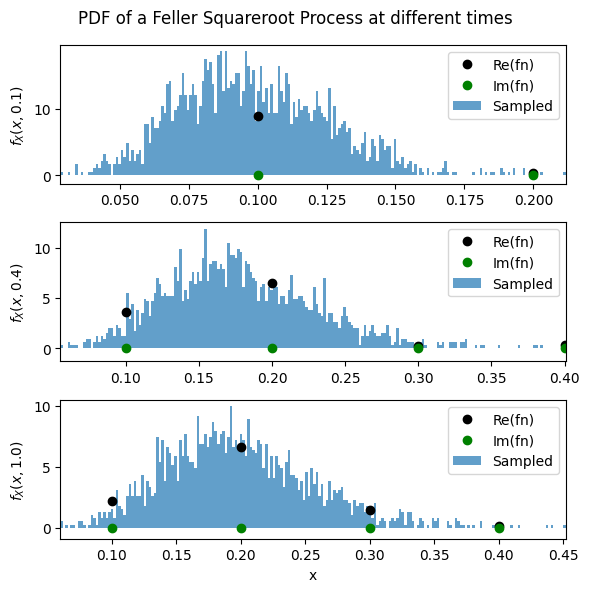

In [5]:
# FT Approx of Pdf using IFFT
kappa = 5
theta = 0.2
sigma = 0.4
r0 = 0.03
T = 1

# Feller_ratio = (2 * alpha * mu) / sigma**2  # for monitoring
k = 2*kappa*theta/(sigma**2)

t = np.linspace(0, T, nsteps + 1)
N = 2048
dx = 0.1
upperx = N * dx
x = dx * np.arange(-N/2, N/2)
dxi = 2 * np.pi / (N * dx)
xi = dxi * np.arange(-N/2, N/2)

def char_func_cir(t, u, v0, kappa, theta, sigma):
    # Parameters for the non-central chi-squared distribution
    ct = 2 * kappa / ((1 - np.exp(-kappa * t)) * sigma**2)
    k = 4 * kappa * theta / sigma**2
    lambda_t = 2 * ct * v0 * np.exp(-kappa * t)

    # Characteristic function of Y
    phi_Y_u = (1 - 1j * u / ct)**(-k / 2) * np.exp(1j * u * lambda_t / (2 * (ct - 1j * u)))

    return phi_Y_u

fig, ax = plt.subplots(3,1, figsize=(6,6))
for i,time in enumerate([20, 80, -1]):

    # Pulsation space: xi
    char_func = char_func_cir(t=t[time], u=xi, v0=r0, kappa = kappa, theta = theta, sigma = sigma)
    f_X = fftshift(fft(ifftshift(char_func))) / upperx

    ax[i].hist(X[time, :],density=True,bins=nsteps, alpha=0.7)
    ax[i].plot(x,np.real(f_X), 'ko', linewidth=2)
    ax[i].plot(x,np.imag(f_X), 'go')
    
    ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
    ax[i].set_xlim(min(X[time,:]), max(X[time,:]))
    ax[i].legend(['Re(fn)', 'Im(fn)','Sampled'])

plt.suptitle('PDF of a Feller Squareroot Process at different times')
plt.xlabel('x')
plt.tight_layout()

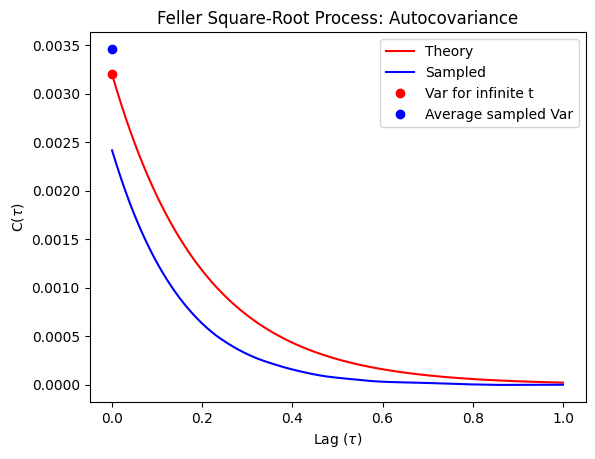

In [8]:
## Autocovariance
from scipy.signal import correlate
# Asymptote for variance as t -> inf
varinf_pt = mu * (sigma**2 / (2 * alpha))

# Initialize the autocovariance array
C = np.zeros((npaths, 2 * nsteps+1))

# Calculate the autocovariance for each path
for i in range(npaths):
    deviation = X[:, i] - EX
    # Compute autocorrelation and normalize by the number of steps
    C[i, :] = correlate(deviation, deviation, mode='full') / nsteps

# Average the autocovariance across all paths
C_mean = np.mean(C, axis=0)

# Theoretical autocovariance as t -> inf
# It can be shown that as we take t -> inf, the covariance simply becomes a function of Tau, the lag. 
# Theoretical value of C_X(t,s) with t<s as we take t -> inf
t = np.linspace(0, T, nsteps+1) 
COVX = np.exp(-alpha * t) * (sigma**2 * mu) / (2 * alpha)

plt.plot(t, COVX, 'r', label='Theory')
plt.plot(t, C_mean[nsteps:], 'b', label='Sampled')
plt.plot(0, varinf_pt, 'ro', label='Var for infinite t')
plt.plot(0, np.mean(np.var(X, axis=0)), 'bo', label='Average sampled Var')
plt.xlabel('Lag ($\\tau$)')
plt.ylabel('C($\\tau$)')
plt.legend(loc='upper right')
plt.title('Feller Square-Root Process: Autocovariance')

# Display the plot
plt.show()

Text(0.5, 1.0, 'Feller Square Root process: autocorrelation')

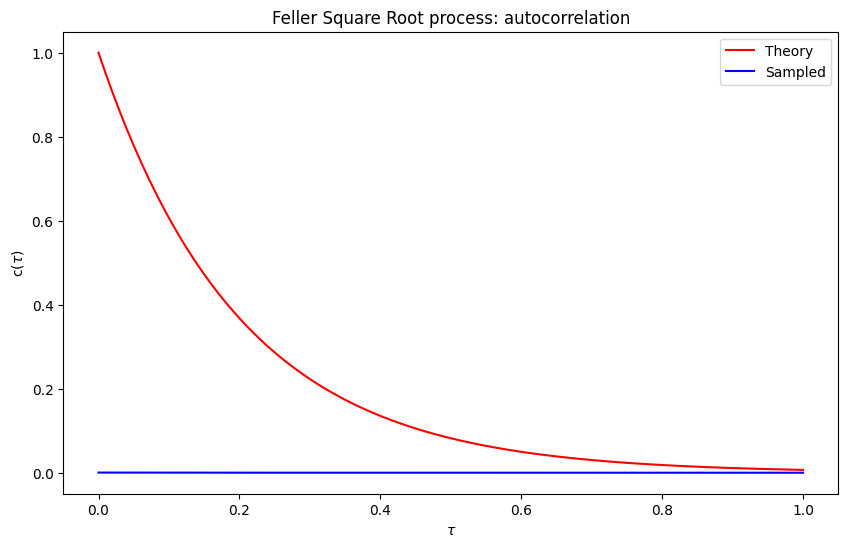

In [ ]:
## Autocorrelation

# The autocorrelation is the Covariance/Variance. However, since our OUP is
# only quasi-stationary (i.e. it is only stationary in the limit t -> inf)
# we will compute the autocorrelation as we have done above, in the limit
# as t -> inf

# It can be shown that in the limit, the autocorrelation becomes
# Corr(t,s) = exp(-1*alpha*tau)     with t < s

# Theoretical autocorrelation
t = np.linspace(0, T, nsteps) 
CORRX = np.exp(-alpha * t)

# Begin plotting
plt.figure(figsize=(10, 6))

# Plot theoretical autocorrelation as a red line
plt.plot(t, CORRX, 'r', label='Theory')

# Plot sampled autocorrelation
# The sampled autocorrelation is computed as the autocovariance divided by the variance at time 0 (C[nsteps+1])
# Here, we use the second half of C (corresponding to non-negative lags)
plt.plot(t, (C_mean[-nsteps:] / C[nsteps]), 'b', label='Sampled')

# Add labels, legend, and title
plt.xlabel(r'$\tau$')
plt.ylabel(r'c($\tau$)')
plt.legend()
plt.title('Feller Square Root process: autocorrelation')

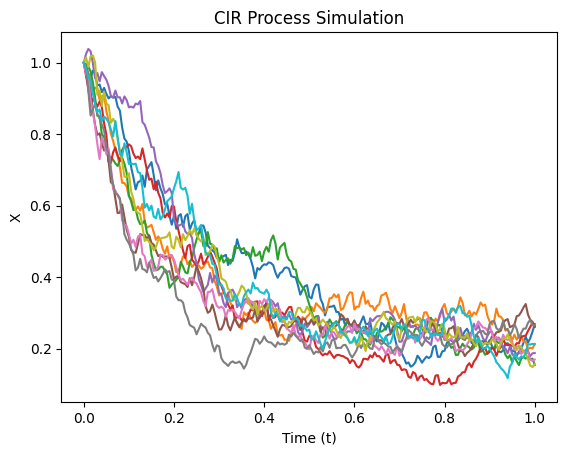

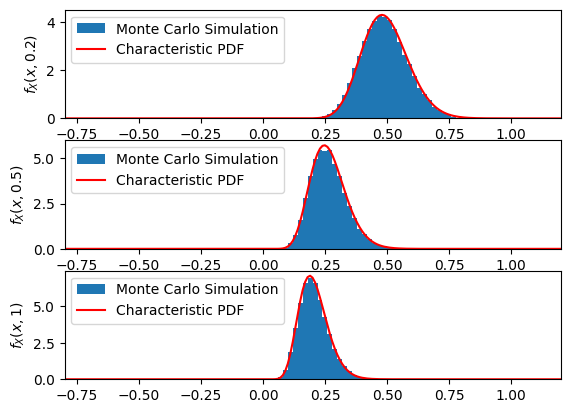

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fourier Transformation in Feller Square Root (CIR) Process
# -----------------------------------------------------------------------------
# This guide focuses on simulating the Cox-Ingersoll-Ross (CIR) process,
# a type of Feller Square Root process, and analyzing it through Fourier Transformation.
# CIR process is often used in financial mathematics to model interest rates.

# CIR Process Equation: dX(t) = α(μ - X(t))dt + σ√X(t)dW(t)
# where α is the mean reversion speed, μ is the long-term mean level,
# σ is the volatility, and dW(t) is the Wiener process increment.

# The guide includes:
# 1. Simulation of the CIR process
# 2. Fourier Transformation and comparison with simulated data

# 1. SIMULATION OF THE CIR PROCESS
# Define simulation parameters and time grid
npaths = 20000  # Number of paths
T = 1  # Time horizon
nsteps = 200  # Number of time steps
dt = T / nsteps  # Time step
t = np.arange(0, T + dt, dt)  # Observation times

# Model parameters
alpha = 5
mu = 0.2
sigma = 0.4
S0 = 1  # Initial value
Feller_ratio = (2 * alpha * mu) / sigma**2  # Checking Feller condition

# Initialize paths
X = np.zeros((nsteps + 1, npaths))
X[0, :] = S0

# Generate random numbers
N = np.random.randn(nsteps, npaths)  # Standard normal random numbers

# Euler-Maruyama method for CIR process
for i in range(nsteps):
    X[i + 1, :] = X[i, :] + alpha * (mu - X[i, :]) * dt + \
                  sigma * np.sqrt(X[i, :] * dt) * N[i, :]
    X[i + 1, :] = np.maximum(X[i + 1, :], np.zeros(npaths))  # Ensure non-negativity

# Plotting the CIR process
plt.figure(1)
plt.plot(t, X[:, :10])
plt.xlabel("Time (t)")
plt.ylabel("X")
plt.title("CIR Process Simulation")


# 2. FOURIER TRANSFORMATION OF THE CIR PROCESS
# Fourier Transformation parameters
N = 2048  # Grid size
Dx = 0.01  # Grid step in real space
Lx = N * Dx  # Upper limit in real space
Dxi = 2 * np.pi / Lx  # Grid step in Fourier space
x = Dx * np.arange(-N/2, N/2)  # Real space grid
xi = Dxi * np.arange(-N/2, N/2)  # Fourier space grid

# CIR parameters for characteristic function
kappa = 5
theta = 0.2
sigma = 0.4
r0 = 1
T = 1

k = 4*kappa*theta/(sigma**2)


# Characteristic function for CIR process
def char_func_cir(t, u, v0, kappa, theta, sigma):
    # Parameters for the non-central chi-squared distribution
    ct = 2 * kappa / ((1 - np.exp(-kappa * t)) * sigma**2)
    k = 4 * kappa * theta / sigma**2
    lambda_t = 2 * ct * v0 * np.exp(-kappa * t)

    # Characteristic function of Y
    phi_Y_u = (1 - 1j * u / ct)**(-k / 2) * np.exp(1j * u * lambda_t / (2 * (ct - 1j * u)))

    return phi_Y_u

# Inverse Fourier Transformation
fn_point2 = np.fft.fftshift(np.fft.fft(
    np.fft.ifftshift(char_func_cir(0.2, xi, r0, kappa, theta, sigma)))) / Lx  # t=0.2
fn_point5 = np.fft.fftshift(np.fft.fft(
    np.fft.ifftshift(char_func_cir(0.5, xi, r0, kappa, theta, sigma)))) / Lx  # t=0.5
fn_1 = np.fft.fftshift(np.fft.fft(
    np.fft.ifftshift(char_func_cir(1, xi, r0, kappa, theta, sigma)))) / Lx  # t=1

# Plotting real probability density functions (PDFs) at different times
plt.figure(2)

# Plot at t=0.2
plt.subplot(3, 1, 1)
plt.hist(X[40, :], bins=np.arange(-0.8, 1.21, 0.02), density=True, label='Monte Carlo Simulation')
plt.plot(x, np.real(fn_point2), 'r',  label='Characteristic PDF')
plt.xlim([-0.8, 1.2])
plt.ylabel(f'$f_X(x,0.2)$')
plt.legend(loc = 'upper left')

# Plot at t=0.5
plt.subplot(3, 1, 2)
plt.hist(X[100, :], bins=np.arange(-0.8, 1.21, 0.02), density=True, label='Monte Carlo Simulation')
plt.plot(x, np.real(fn_point5), 'r',  label='Characteristic PDF')
plt.xlim([-0.8, 1.2])
plt.ylabel(f'$f_X(x,0.5)$')
plt.legend(loc = 'upper left')

# Plot at t=1
plt.subplot(3, 1, 3)
plt.hist(X[-1, :], bins=np.arange(-0.8, 1.21, 0.02), density=True, label='Monte Carlo Simulation')
plt.plot(x, np.real(fn_1), 'r',  label='Characteristic PDF')
plt.xlim([-0.8, 1.2])
plt.ylabel(f'$f_X(x,1)$')
plt.legend(loc = 'upper left')

plt.show()